<a href="https://colab.research.google.com/github/Sujoy-004/Chat-Analyzer-Pro/blob/main/notebooks/03_sentiment_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cell 1 : verify environment and available data

In [49]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path

In [50]:
try:
    # Try to load your processed data
    df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
    print("✅ Successfully loaded your processed chat data!")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print()
    print("Sample data:")
    print(df.head(3).to_string())
    print()
    print("Data types:")
    print(df.dtypes)
    print()

except Exception as e:
    print(f"❌ Error loading data: {e}")

✅ Successfully loaded your processed chat data!
Data shape: (27, 7)
Columns: ['datetime', 'sender', 'message', 'date', 'time', 'hour', 'message_length']

Sample data:
              datetime sender                                                                    message        date      time  hour  message_length
0  2023-12-25 09:30:00  Alice                                                        Merry Christmas! 🎄🎅  2023-12-25  09:30:00     9              19
1  2023-12-25 09:32:00    Bob                 Merry Christmas to you too! Hope you're having a great day  2023-12-25  09:32:00     9              58
2  2023-12-25 09:35:00  Alice  Thanks! Opening presents with family right now Family time is the best ❤️  2023-12-25  09:35:00     9              73

Data types:
datetime          object
sender            object
message           object
date              object
time              object
hour               int64
message_length     int64
dtype: object



In [51]:
# Check for VADER
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("✅ VADER Sentiment is available")
    vader_available = True
except ImportError:
    print("❌ VADER Sentiment not installed")
    vader_available = False

✅ VADER Sentiment is available


In [52]:
# Check for TextBlob
try:
    from textblob import TextBlob
    print("✅ TextBlob is available")
    textblob_available = True
except ImportError:
    print("❌ TextBlob not installed")
    textblob_available = False

✅ TextBlob is available


In [53]:
# Check for transformers (HuggingFace)
try:
    from transformers import pipeline
    print("✅ Transformers (HuggingFace) is available")
    transformers_available = True
except ImportError:
    print("❌ Transformers not installed")
    transformers_available = False

✅ Transformers (HuggingFace) is available


In [54]:
# Check for matplotlib and seaborn for visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("✅ Matplotlib and Seaborn available")
    viz_available = True
except ImportError:
    print("❌ Visualization libraries not available")
    viz_available = False

✅ Matplotlib and Seaborn available


## Cell 2: Install VADER and Import Required Libraries

In [55]:
print("Installing VADER Sentiment...")
!pip install vaderSentiment
print("✅ VADER Sentiment installed")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

Installing VADER Sentiment...
✅ VADER Sentiment installed


In [56]:
# Test VADER
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    vader_analyzer = SentimentIntensityAnalyzer()
    test_text = "I love this amazing day!"
    vader_result = vader_analyzer.polarity_scores(test_text)
    print("✅ VADER working:", vader_result)
except Exception as e:
    print(f"❌ VADER error: {e}")

✅ VADER working: {'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compound': 0.8748}


In [57]:
# Test TextBlob
try:
    from textblob import TextBlob
    blob = TextBlob(test_text)
    print("✅ TextBlob working - Polarity:", blob.sentiment.polarity, "Subjectivity:", blob.sentiment.subjectivity)
except Exception as e:
    print(f"❌ TextBlob error: {e}")

✅ TextBlob working - Polarity: 0.625 Subjectivity: 0.75


In [58]:
# Test Transformers (HuggingFace) - this will take time to download
try:
    from transformers import pipeline
    # We'll use a lightweight model for sentiment
    print("✅ Loading HuggingFace sentiment pipeline...")
    hf_analyzer = pipeline("sentiment-analysis",
                          model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                          return_all_scores=True)
    hf_result = hf_analyzer(test_text)
    print("✅ HuggingFace working:", hf_result)
except Exception as e:
    print(f"❌ HuggingFace error: {e}")
    print("Trying alternative model...")
    try:
        hf_analyzer = pipeline("sentiment-analysis", return_all_scores=True)
        hf_result = hf_analyzer(test_text)
        print("✅ HuggingFace (default) working:", hf_result)
    except Exception as e2:
        print(f"❌ HuggingFace (default) error: {e2}")

✅ Loading HuggingFace sentiment pipeline...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ HuggingFace working: [[{'label': 'negative', 'score': 0.007204313296824694}, {'label': 'neutral', 'score': 0.009917495772242546}, {'label': 'positive', 'score': 0.9828782081604004}]]


In [59]:
df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"\n📊 Analyzing {len(df)} messages from {df['sender'].unique()}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")


📊 Analyzing 27 messages from ['Alice' 'Bob']
Date range: 2023-12-25 09:30:00 to 2023-12-27 08:15:00


##  Cell 3: Sentiment Analysis Functions

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [61]:
print("📥 Downloading sentiment.py from your repository...")
import requests

# Load the sentiment analysis module from GitHub
sentiment_code = requests.get('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/src/analysis/sentiment.py').text

# Execute the code in the global scope to make functions accessible
exec(sentiment_code, globals())

📥 Downloading sentiment.py from your repository...
📊 Sentiment Analysis Module - Chat Analyzer Pro
This module provides comprehensive sentiment analysis for chat data
Usage: import sentiment; sentiment.quick_sentiment_analysis(df)


In [62]:
print("✅ sentiment.py module loaded successfully!")
print("🔧 Available functions:")
print("  ✅ analyze_vader()")
print("  ✅ analyze_textblob()")
print("  ✅ analyze_huggingface()")
print("  ✅ add_sentiment_analysis()")
print("  ✅ get_sentiment_summary()")
print("  ✅ plot_sentiment_analysis()")
print("  ✅ find_extreme_messages()")
print("  ✅ quick_sentiment_analysis()")
print("  ✅ initialize_analyzers()")

✅ sentiment.py module loaded successfully!
🔧 Available functions:
  ✅ analyze_vader()
  ✅ analyze_textblob()
  ✅ analyze_huggingface()
  ✅ add_sentiment_analysis()
  ✅ get_sentiment_summary()
  ✅ plot_sentiment_analysis()
  ✅ find_extreme_messages()
  ✅ quick_sentiment_analysis()
  ✅ initialize_analyzers()


In [63]:
# Load your test data
df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"\n📊 Testing on {len(df)} messages from {df['sender'].unique()}")

# Initialize analyzers first before testing individual functions
print("\n🔧 Initializing analyzers for individual function testing...")
initialize_analyzers()


📊 Testing on 27 messages from ['Alice' 'Bob']

🔧 Initializing analyzers for individual function testing...
🚀 Initializing Sentiment Analyzers...
✅ VADER analyzer loaded


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ HuggingFace analyzer loaded
🎯 Sentiment analyzers ready!


In [64]:
sample_messages = [
    "Merry Christmas! 🎄🎅",
    "That sounds wonderful! I'm cooking dinner for everyone today",
    "<Media omitted>",
    "Thanks for sharing your day with me 😊",
    "Good morning! How was your evening?"
]

In [65]:
for i, msg in enumerate(sample_messages, 1):
    print(f"\n📝 Message {i}: '{msg}'")

    # Test VADER
    vader_result = analyze_vader(msg)
    print(f"  🔵 VADER: {vader_result['compound']:.3f} ({categorize_sentiment(vader_result['compound'])})")
    print(f"      Details: pos={vader_result['pos']:.3f}, neu={vader_result['neu']:.3f}, neg={vader_result['neg']:.3f}")

    # Test TextBlob
    tb_result = analyze_textblob(msg)
    print(f"  🟠 TextBlob: {tb_result['polarity']:.3f} ({categorize_sentiment(tb_result['polarity'])})")
    print(f"      Subjectivity: {tb_result['subjectivity']:.3f}")

    # Test HuggingFace
    hf_result = analyze_huggingface(msg)
    dominant = max(hf_result, key=hf_result.get)
    print(f"  🟢 HuggingFace: {dominant} (confidence: {hf_result[dominant]:.3f})")
    print(f"      All scores: {hf_result}")


📝 Message 1: 'Merry Christmas! 🎄🎅'
  🔵 VADER: 0.585 (Positive)
      Details: pos=0.431, neu=0.569, neg=0.000
  🟠 TextBlob: 0.000 (Neutral)
      Subjectivity: 0.000
  🟢 HuggingFace: positive (confidence: 0.968)
      All scores: {'positive': 0.9682372212409973, 'negative': 0.004698131233453751, 'neutral': 0.027064576745033264}

📝 Message 2: 'That sounds wonderful! I'm cooking dinner for everyone today'
  🔵 VADER: 0.611 (Positive)
      Details: pos=0.333, neu=0.667, neg=0.000
  🟠 TextBlob: 1.000 (Positive)
      Subjectivity: 1.000
  🟢 HuggingFace: positive (confidence: 0.989)
      All scores: {'positive': 0.9893565773963928, 'negative': 0.00198520184494555, 'neutral': 0.00865818839520216}

📝 Message 3: '<Media omitted>'
  🔵 VADER: 0.000 (Neutral)
      Details: pos=0.000, neu=1.000, neg=0.000
  🟠 TextBlob: 0.000 (Neutral)
      Subjectivity: 0.000
  🟢 HuggingFace: neutral (confidence: 0.656)
      All scores: {'positive': 0.030994487926363945, 'negative': 0.3133400082588196, 'neutr

In [66]:
# Test the main analysis function on a small subset
print("Testing add_sentiment_analysis() on first 5 messages...")
test_df = df.head(5).copy()
test_df_analyzed = add_sentiment_analysis(test_df, initialize_first=True)

print(f"\n📊 Results Summary:")
print(f"  Original columns: {len(test_df.columns)}")
print(f"  After analysis: {len(test_df_analyzed.columns)}")
print(f"  New columns added: {len(test_df_analyzed.columns) - len(test_df.columns)}")

Testing add_sentiment_analysis() on first 5 messages...
🚀 Initializing Sentiment Analyzers...
✅ VADER analyzer loaded


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ HuggingFace analyzer loaded
🎯 Sentiment analyzers ready!
🔍 Analyzing sentiment for 5 messages...
Running VADER analysis...
Running TextBlob analysis...
Running HuggingFace analysis...
✅ Sentiment analysis complete!

📊 Results Summary:
  Original columns: 7
  After analysis: 20
  New columns added: 13


In [67]:
# Show the new columns
new_columns = [col for col in test_df_analyzed.columns if col not in test_df.columns]
print(f"\n✅ New sentiment columns:")
for col in new_columns:
    print(f"    - {col}")


✅ New sentiment columns:
    - vader_compound
    - vader_pos
    - vader_neu
    - vader_neg
    - vader_sentiment
    - textblob_polarity
    - textblob_subjectivity
    - textblob_sentiment
    - hf_positive
    - hf_negative
    - hf_neutral
    - hf_sentiment
    - consensus_sentiment


In [68]:
# Test summary function
print(f"\n📝 Testing get_sentiment_summary()...")
summary = get_sentiment_summary(test_df_analyzed)
print(f"  Summary keys: {list(summary.keys())}")
print(f"  Sentiment distribution: {summary.get('sentiment_distribution', 'N/A')}")


📝 Testing get_sentiment_summary()...
  Summary keys: ['total_messages', 'sentiment_distribution', 'average_scores', 'by_sender', 'temporal_analysis']
  Sentiment distribution: {'Positive': 4, 'Neutral': 1}


In [69]:
# Test extreme messages function
print(f"\n🎭 Testing find_extreme_messages()...")
extremes = find_extreme_messages(test_df_analyzed, n=2)
print(f"  Found {len(extremes['most_positive'])} most positive messages")
print(f"  Found {len(extremes['most_negative'])} most negative messages")


🎭 Testing find_extreme_messages()...
  Found 2 most positive messages
  Found 2 most negative messages


## Cell 4: Full Sentiment Analysis and Visualization

In [70]:
import requests
sentiment_code = requests.get('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/src/analysis/sentiment.py').text
exec(sentiment_code, globals())

print("✅ sentiment.py module loaded successfully!")

📊 Sentiment Analysis Module - Chat Analyzer Pro
This module provides comprehensive sentiment analysis for chat data
Usage: import sentiment; sentiment.quick_sentiment_analysis(df)
✅ sentiment.py module loaded successfully!


In [71]:
# Load your data
df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"📊 Analyzing {len(df)} messages from {df['sender'].unique()}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")

📊 Analyzing 27 messages from ['Alice' 'Bob']
Date range: 2023-12-25 09:30:00 to 2023-12-27 08:15:00


🚀 Initializing Sentiment Analyzers...
✅ VADER analyzer loaded


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ HuggingFace analyzer loaded
🎯 Sentiment analyzers ready!
🔍 Analyzing sentiment for 27 messages...
Running VADER analysis...
Running TextBlob analysis...
Running HuggingFace analysis...
✅ Sentiment analysis complete!


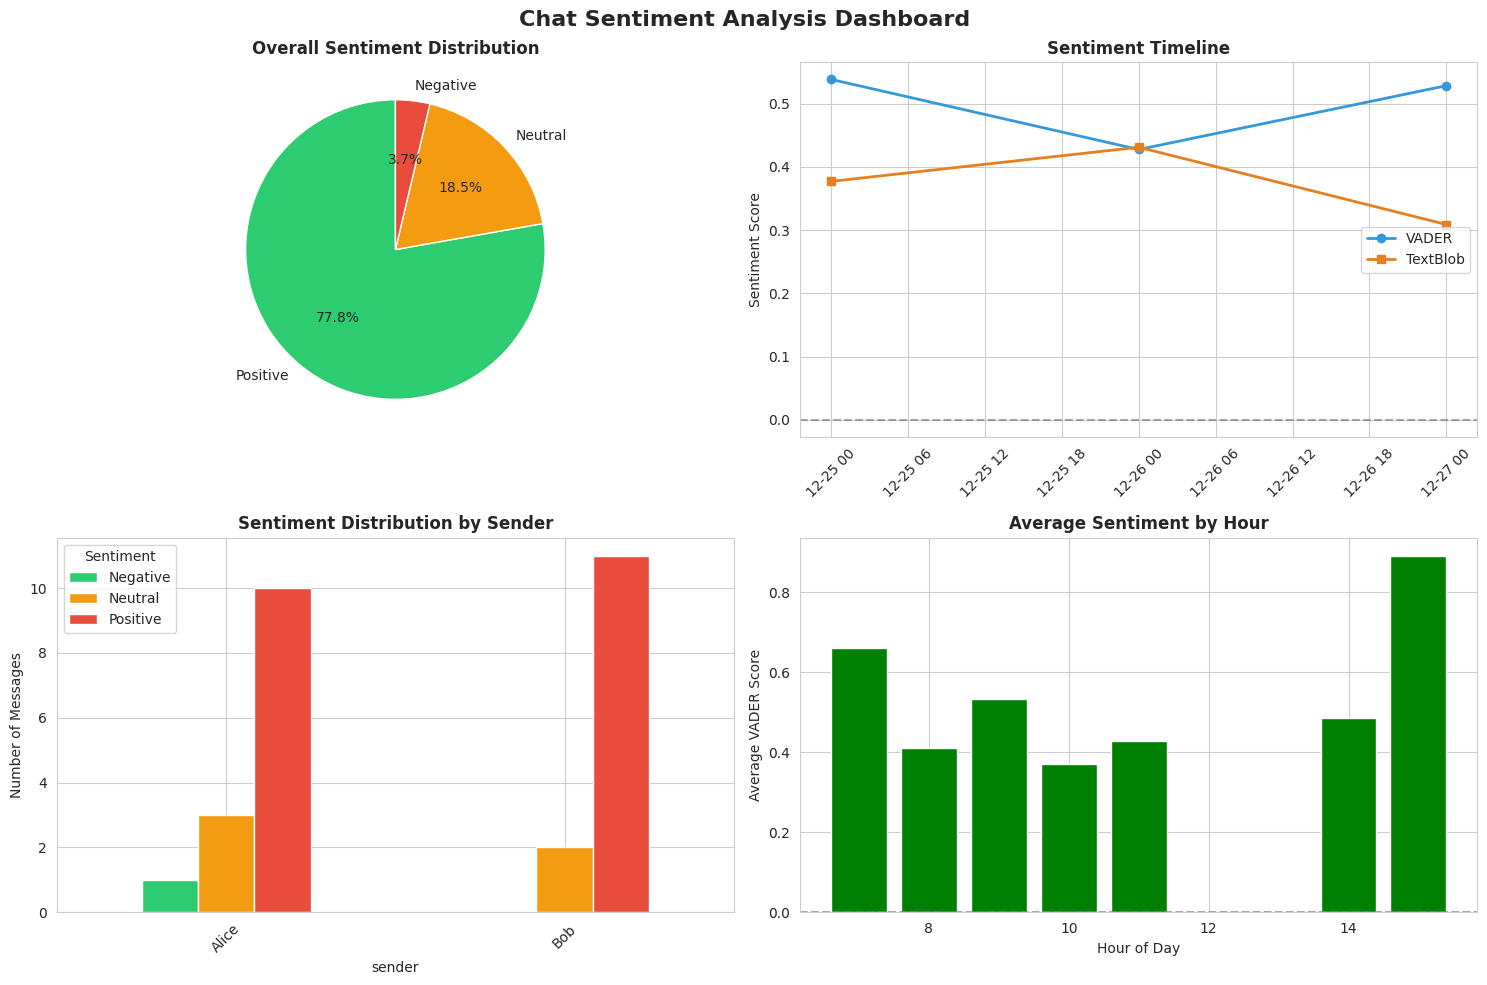


📈 SENTIMENT ANALYSIS RESULTS
Total Messages: 27

🎭 Overall Sentiment Distribution:
  Positive: 21 messages (77.8%)
  Neutral: 5 messages (18.5%)
  Negative: 1 messages (3.7%)

📊 Average Sentiment Scores:
  vader_compound: 0.504 (min: 0.000, max: 0.929)
  textblob_polarity: 0.378 (min: -0.150, max: 1.000)

👥 Sentiment by Sender:
  Alice:
    Messages: 14
    Avg vader_compound: 0.425
    Avg textblob_polarity: 0.204
    Positive: 10 (71.4%)
    Neutral: 3 (21.4%)
    Negative: 1 (7.1%)

  Bob:
    Messages: 13
    Avg vader_compound: 0.588
    Avg textblob_polarity: 0.566
    Positive: 11 (84.6%)
    Neutral: 2 (15.4%)



In [72]:
df_with_sentiment, summary = quick_sentiment_analysis(df, plot=True)

print("\n" + "="*60)
print("📈 SENTIMENT ANALYSIS RESULTS")
print("="*60)

print(f"Total Messages: {summary['total_messages']}")
print(f"\n🎭 Overall Sentiment Distribution:")
for sentiment, count in summary['sentiment_distribution'].items():
    percentage = (count / summary['total_messages']) * 100
    print(f"  {sentiment}: {count} messages ({percentage:.1f}%)")

print(f"\n📊 Average Sentiment Scores:")
for score_type, scores in summary['average_scores'].items():
    print(f"  {score_type}: {scores['mean']:.3f} (min: {scores['min']:.3f}, max: {scores['max']:.3f})")

print(f"\n👥 Sentiment by Sender:")
for sender, data in summary['by_sender'].items():
    print(f"  {sender}:")
    print(f"    Messages: {data['message_count']}")
    for score_type, avg_score in data['avg_scores'].items():
        print(f"    Avg {score_type}: {avg_score:.3f}")
    sentiment_dist = data['sentiment_distribution']
    for sent, count in sentiment_dist.items():
        pct = (count / data['message_count']) * 100
        print(f"    {sent}: {count} ({pct:.1f}%)")
    print()

In [73]:
extreme_messages = find_extreme_messages(df_with_sentiment, n=2)

print("\n" + "="*60)
print("🔍 EXTREME MESSAGES ANALYSIS")
print("="*60)

print("🟢 MOST POSITIVE MESSAGES:")
for i, msg_data in enumerate(extreme_messages['most_positive'], 1):
    print(f"  {i}. Sender: {msg_data['sender']}")
    print(f"     Message: '{msg_data['message']}'")
    print(f"     VADER Score: {msg_data['vader_score']:.3f}")
    print(f"     Sentiment: {msg_data['sentiment']}")
    print()

print("🔴 MOST NEGATIVE MESSAGES:")
for i, msg_data in enumerate(extreme_messages['most_negative'], 1):
    print(f"  {i}. Sender: {msg_data['sender']}")
    print(f"     Message: '{msg_data['message']}'")
    print(f"     VADER Score: {msg_data['vader_score']:.3f}")
    print(f"     Sentiment: {msg_data['sentiment']}")
    print()


🔍 EXTREME MESSAGES ANALYSIS
🟢 MOST POSITIVE MESSAGES:
  1. Sender: Alice
     Message: 'It definitely will be! Thanks for sharing your day with me 😊'
     VADER Score: 0.929
     Sentiment: Positive

  2. Sender: Bob
     Message: 'Merry Christmas to you too! Hope you're having a great day'
     VADER Score: 0.895
     Sentiment: Positive

🔴 MOST NEGATIVE MESSAGES:
  1. Sender: Alice
     Message: '<Media omitted>'
     VADER Score: 0.000
     Sentiment: Neutral

  2. Sender: Alice
     Message: 'Here's our Christmas tree!'
     VADER Score: 0.000
     Sentiment: Neutral



In [74]:
# Show final data structure
print("📋 FINAL DATA STRUCTURE:")
print(f"Shape: {df_with_sentiment.shape}")
print(f"Sentiment columns added by your module:")
sentiment_columns = [col for col in df_with_sentiment.columns if any(word in col.lower()
                    for word in ['vader', 'textblob', 'hf', 'sentiment'])]
for col in sentiment_columns:
    print(f"  ✅ {col}")

📋 FINAL DATA STRUCTURE:
Shape: (27, 20)
Sentiment columns added by your module:
  ✅ vader_compound
  ✅ vader_pos
  ✅ vader_neu
  ✅ vader_neg
  ✅ vader_sentiment
  ✅ textblob_polarity
  ✅ textblob_subjectivity
  ✅ textblob_sentiment
  ✅ hf_positive
  ✅ hf_negative
  ✅ hf_neutral
  ✅ hf_sentiment
  ✅ consensus_sentiment


## Cell 5: Install Additional Dependencies for Emotion Analysis

In [75]:
print("📦 Installing emotion analysis dependencies...")
print("This may take a few minutes...")
!pip install -q transformers torch

print("✅ Dependencies installed!")

# Verify installation
try:
    import transformers
    import torch
    print(f"✅ Transformers version: {transformers.__version__}")
    print(f"✅ PyTorch version: {torch.__version__}")
except Exception as e:
    print(f"❌ Installation issue: {e}")

📦 Installing emotion analysis dependencies...
This may take a few minutes...
✅ Dependencies installed!
✅ Transformers version: 4.56.1
✅ PyTorch version: 2.8.0+cu126


## Cell 6: Load Emotion Analysis Module

In [76]:
print("📥 Loading emotion analysis module...")
import requests

emotion_code = requests.get(
    'https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/src/analysis/emotion.py'
).text

# Execute the code to make functions available
exec(emotion_code, globals())

print("\n✅ emotion.py module loaded successfully!")
print("🔧 Available classes and functions:")
print("  ✅ EmotionAnalyzer (main class)")
print("  ✅ quick_emotion_analysis()")
print("  ✅ plot_emotion_analysis()")
print("  ✅ combine_sentiment_emotion()")

📥 Loading emotion analysis module...
🎭 Emotion Classification Module - Chat Analyzer Pro
This module provides advanced emotion analysis using transformers
Usage: from emotion import EmotionAnalyzer; analyzer = EmotionAnalyzer()

✅ emotion.py module loaded successfully!
🔧 Available classes and functions:
  ✅ EmotionAnalyzer (main class)
  ✅ quick_emotion_analysis()
  ✅ plot_emotion_analysis()
  ✅ combine_sentiment_emotion()


## Cell 7: Initialize Emotion Analyzer and Test

In [77]:
print("🎭 Initializing Emotion Analyzer...")
emotion_analyzer = EmotionAnalyzer()

# Test on sample messages
sample_messages = [
    "I'm so happy and excited about this! 🎉",
    "This makes me really sad and disappointed 😢",
    "I'm furious about what happened!",
    "That's absolutely terrifying!",
    "Wow! I never expected this!",
    "I love you so much ❤️"
]

print("\n📝 Testing emotion detection on sample messages:\n")
for i, msg in enumerate(sample_messages, 1):
    emotions = emotion_analyzer.analyze_single_message(msg)
    dominant = max(emotions, key=emotions.get)
    confidence = emotions[dominant]

    print(f"{i}. '{msg}'")
    print(f"   🎭 Dominant: {dominant.upper()} (confidence: {confidence:.2%})")
    print(f"   📊 All scores: {', '.join([f'{k}: {v:.3f}' for k, v in emotions.items()])}\n")

🎭 Initializing Emotion Analyzer...
🚀 Loading emotion classification model: j-hartmann/emotion-english-distilroberta-base
   This may take a moment on first run...


Device set to use cpu


✅ Emotion model loaded successfully!

📝 Testing emotion detection on sample messages:

1. 'I'm so happy and excited about this! 🎉'
   🎭 Dominant: JOY (confidence: 98.43%)
   📊 All scores: joy: 0.984, surprise: 0.009, neutral: 0.003, sadness: 0.001, anger: 0.001, disgust: 0.000, fear: 0.000, love: 0.000

2. 'This makes me really sad and disappointed 😢'
   🎭 Dominant: SADNESS (confidence: 98.69%)
   📊 All scores: sadness: 0.987, neutral: 0.005, surprise: 0.003, disgust: 0.002, joy: 0.001, anger: 0.001, fear: 0.001, love: 0.000

3. 'I'm furious about what happened!'
   🎭 Dominant: ANGER (confidence: 98.46%)
   📊 All scores: anger: 0.985, neutral: 0.004, surprise: 0.003, fear: 0.003, disgust: 0.002, sadness: 0.002, joy: 0.001, love: 0.000

4. 'That's absolutely terrifying!'
   🎭 Dominant: FEAR (confidence: 97.69%)
   📊 All scores: fear: 0.977, surprise: 0.009, neutral: 0.005, disgust: 0.003, anger: 0.003, sadness: 0.002, joy: 0.001, love: 0.000

5. 'Wow! I never expected this!'
   🎭 Domina

## Cell 8: Analyze Emotions in Your Chat Data

In [78]:
df = pd.read_csv('https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"🎭 Analyzing emotions in {len(df)} messages...")

# Perform emotion analysis
df_emotions = emotion_analyzer.analyze_emotions(df, text_column='message')

print("\n✅ Emotion analysis complete!")
print(f"📊 Added columns: {[col for col in df_emotions.columns if col.startswith('emotion_')]}")
print(f"\nFirst few results:")
display(df_emotions[['sender', 'message', 'dominant_emotion', 'emotion_confidence']].head(10))

🎭 Analyzing emotions in 27 messages...

🎭 Analyzing emotions for 27 messages...
✅ Emotion analysis complete!

✅ Emotion analysis complete!
📊 Added columns: ['emotion_joy', 'emotion_sadness', 'emotion_anger', 'emotion_fear', 'emotion_surprise', 'emotion_love', 'emotion_neutral', 'emotion_disgust', 'emotion_confidence']

First few results:


,sender,message,dominant_emotion,emotion_confidence
0,Alice,Merry Christmas! 🎄🎅,joy,0.717347
1,Bob,Merry Christmas to you too! Hope you're having...,joy,0.849528
2,Alice,Thanks! Opening presents with family right now...,joy,0.869084
3,Bob,That sounds wonderful! I'm cooking dinner for ...,joy,0.975010
4,Alice,<Media omitted>,joy,0.166667
5,Alice,Here's our Christmas tree!,joy,0.615281
6,Bob,Beautiful tree! 😍 Our dinner is almost ready,joy,0.947543
7,Alice,Can't wait to see photos!,joy,0.974433
8,Bob,<Media omitted>,joy,0.166667
9,Bob,Christmas dinner success! 🍽️,joy,0.732329


## Cell 9: Emotion Analysis Summary Statistics

In [79]:
summary = emotion_analyzer.get_emotion_summary(df_emotions)

print("="*70)
print("📊 EMOTION ANALYSIS SUMMARY")
print("="*70)

print(f"\n📈 Total Messages: {summary['total_messages']}")

print(f"\n🎭 Emotion Distribution:")
for emotion, count in summary['emotion_distribution'].items():
    percentage = (count / summary['total_messages']) * 100
    bar = '█' * int(percentage / 2)
    print(f"  {emotion.capitalize():12s}: {count:3d} messages ({percentage:5.1f}%) {bar}")

print(f"\n📊 Average Emotion Scores:")
for emotion, score in summary['average_emotion_scores'].items():
    print(f"  {emotion.capitalize():12s}: {score:.4f}")

if 'by_sender' in summary:
    print(f"\n👥 Emotion Analysis by Sender:")
    for sender, data in summary['by_sender'].items():
        print(f"\n  {sender} ({data['message_count']} messages):")
        print(f"    Dominant emotions: {data['dominant_emotions']}")
        print(f"    Top 3 emotion scores:")
        top_emotions = sorted(data['avg_emotion_scores'].items(),
                            key=lambda x: x[1], reverse=True)[:3]
        for emotion, score in top_emotions:
            print(f"      {emotion}: {score:.4f}")

📊 EMOTION ANALYSIS SUMMARY

📈 Total Messages: 27

🎭 Emotion Distribution:
  Joy         :  23 messages ( 85.2%) ██████████████████████████████████████████
  Surprise    :   3 messages ( 11.1%) █████
  Anger       :   1 messages (  3.7%) █

📊 Average Emotion Scores:
  Joy         : 0.6308
  Sadness     : 0.0268
  Anger       : 0.0369
  Fear        : 0.0165
  Surprise    : 0.1102
  Love        : 0.0123

👥 Emotion Analysis by Sender:

  Alice (14 messages):
    Dominant emotions: {'joy': 12, 'surprise': 2}
    Top 3 emotion scores:
      joy: 0.6178
      surprise: 0.1347
      sadness: 0.0326

  Bob (13 messages):
    Dominant emotions: {'joy': 11, 'anger': 1, 'surprise': 1}
    Top 3 emotion scores:
      joy: 0.6448
      surprise: 0.0838
      anger: 0.0547


## Cell 10: Find Most Emotional Messages

In [80]:
print("🎭 MOST EMOTIONAL MESSAGES\n")

emotions_to_check = ['joy', 'sadness', 'anger', 'love']

for emotion in emotions_to_check:
    print(f"\n{'='*70}")
    print(f"💬 Top 3 messages with highest {emotion.upper()}:")
    print('='*70)

    top_messages = emotion_analyzer.find_most_emotional_messages(
        df_emotions, emotion=emotion, n=3
    )

    for idx, row in top_messages.iterrows():
        print(f"\n{row['sender']} ({row['datetime']}):")
        print(f"  Message: {row['message']}")
        print(f"  {emotion.capitalize()} score: {row[f'emotion_{emotion}']:.4f}")
        print(f"  Dominant: {row['dominant_emotion']}")


🎭 MOST EMOTIONAL MESSAGES


💬 Top 3 messages with highest JOY:

Bob (2023-12-25 10:15:00):
  Message: That sounds wonderful! I'm cooking dinner for everyone today
  Joy score: 0.9750
  Dominant: joy

Alice (2023-12-25 11:45:00):
  Message: Can't wait to see photos!
  Joy score: 0.9744
  Dominant: joy

Bob (2023-12-26 08:30:00):
  Message: Morning! It was great, played some games with the family
  Joy score: 0.9645
  Dominant: joy

💬 Top 3 messages with highest SADNESS:

Alice (2023-12-25 10:16:00):
  Message: <Media omitted>
  Sadness score: 0.1667
  Dominant: joy

Bob (2023-12-25 14:30:00):
  Message: <Media omitted>
  Sadness score: 0.1667
  Dominant: joy

Alice (2023-12-26 10:00:00):
  Message: Home Alone and Elf - the classics! 😄
  Sadness score: 0.1219
  Dominant: joy

💬 Top 3 messages with highest ANGER:

Bob (2023-12-26 08:31:00):
  Message: How about you?
  Anger score: 0.4296
  Dominant: anger

Alice (2023-12-25 10:16:00):
  Message: <Media omitted>
  Anger score: 0.1667
  Dom

## Cell 11: Emotion Timeline Visualization

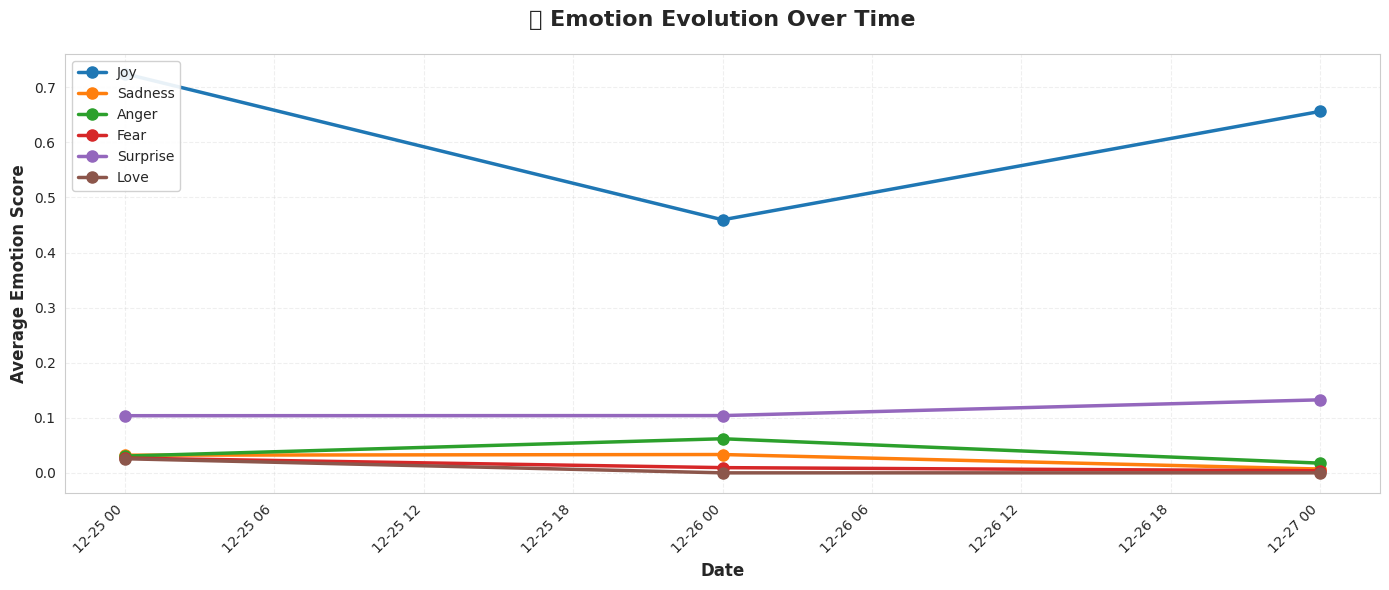

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get emotion timeline
timeline = emotion_analyzer.get_emotion_timeline(df_emotions)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 6))

for emotion in emotion_analyzer.emotions:
    ax.plot(timeline['date'], timeline[f'emotion_{emotion}'],
            marker='o', label=emotion.capitalize(), linewidth=2.5, markersize=8)

ax.set_title('🎭 Emotion Evolution Over Time', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Emotion Score', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Cell 12: Combined Sentiment & Emotion Dashboard

✅ Using cached emotion model


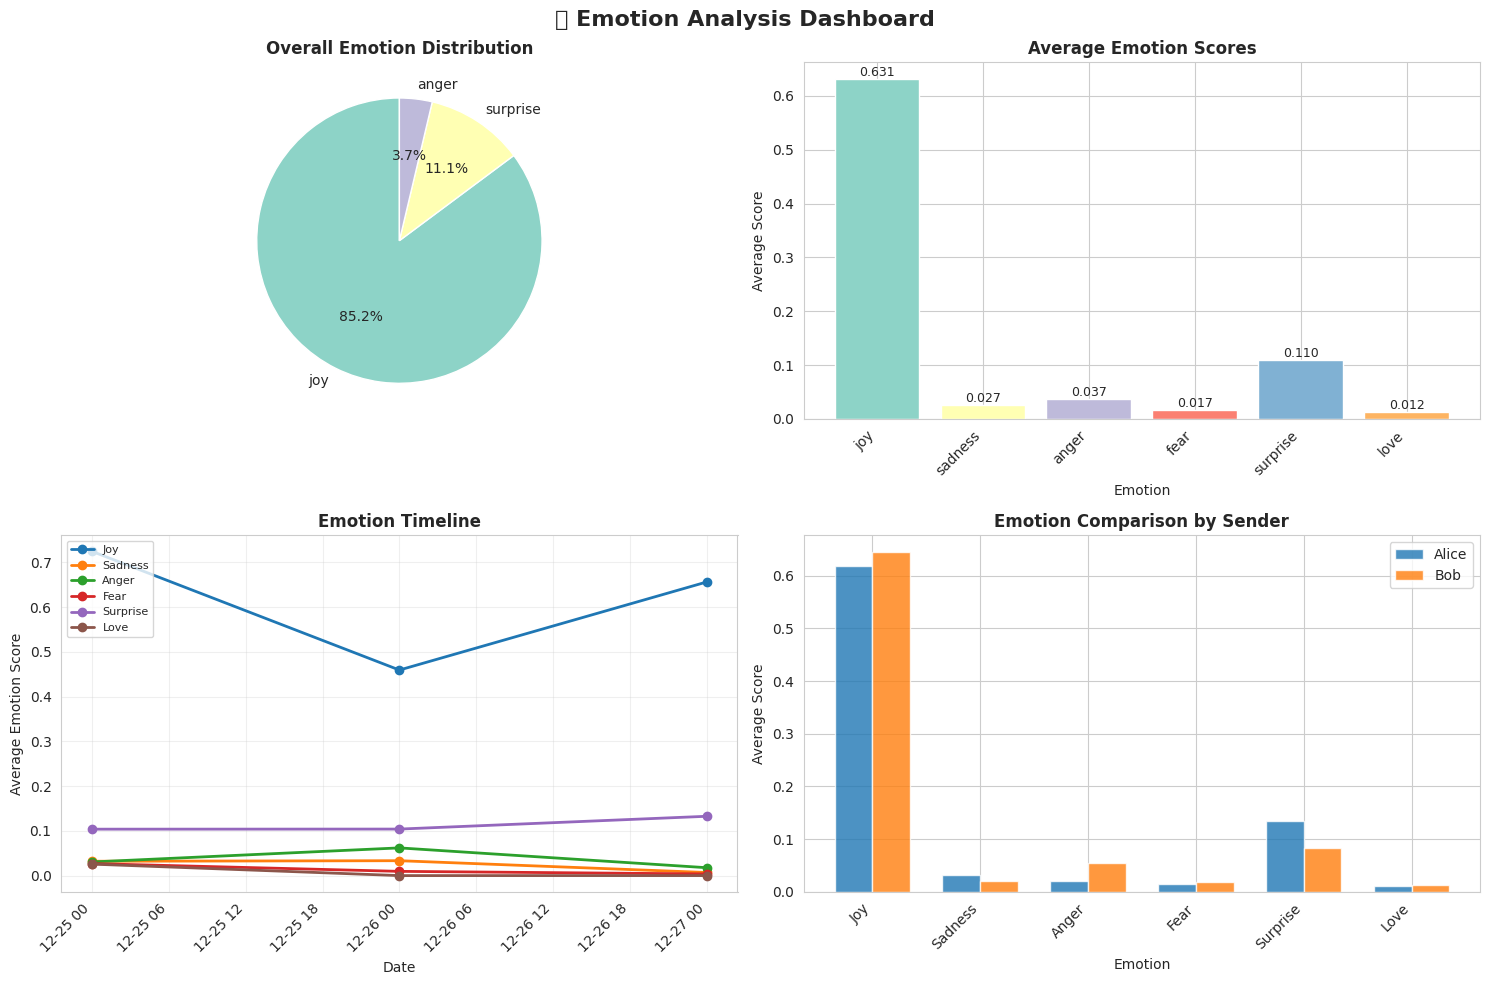

In [82]:
# Generate full emotion visualization dashboard
plot_emotion_analysis(df_emotions, summary)

## Cell 13: Combine with Previous Sentiment Analysis

In [83]:
if 'vader_compound' in df.columns or 'df_with_sentiment' in locals():
    print("🔄 Combining sentiment and emotion analysis...")

    # Use the sentiment dataframe if available
    if 'df_with_sentiment' in locals():
        df_complete = combine_sentiment_emotion(df_with_sentiment, df_emotions)
    else:
        # Reload sentiment if needed
        print("  Loading sentiment data...")
        # Re-run sentiment analysis
        df_with_sentiment, sent_summary = quick_sentiment_analysis(df, plot=False)
        df_complete = combine_sentiment_emotion(df_with_sentiment, df_emotions)

    print("✅ Combined analysis complete!")
    print(f"   Total columns: {len(df_complete.columns)}")
    print(f"   Sentiment columns: {[col for col in df_complete.columns if 'vader' in col or 'textblob' in col or 'hf_' in col]}")
    print(f"   Emotion columns: {[col for col in df_complete.columns if 'emotion_' in col]}")

    # Show sample
    print("\n📊 Sample combined analysis:")
    display(df_complete[['sender', 'message', 'consensus_sentiment',
                         'dominant_emotion', 'emotion_confidence']].head(10))

else:
    print("ℹ️  No sentiment analysis found. Run sentiment analysis first to combine results.")

🔄 Combining sentiment and emotion analysis...
✅ Combined analysis complete!
   Total columns: 30
   Sentiment columns: ['vader_compound', 'vader_pos', 'vader_neu', 'vader_neg', 'vader_sentiment', 'textblob_polarity', 'textblob_subjectivity', 'textblob_sentiment', 'hf_positive', 'hf_negative', 'hf_neutral', 'hf_sentiment']
   Emotion columns: ['emotion_joy', 'emotion_sadness', 'emotion_anger', 'emotion_fear', 'emotion_surprise', 'emotion_love', 'emotion_neutral', 'emotion_disgust', 'emotion_confidence']

📊 Sample combined analysis:


,sender,message,consensus_sentiment,dominant_emotion,emotion_confidence
0,Alice,Merry Christmas! 🎄🎅,Positive,joy,0.717347
1,Bob,Merry Christmas to you too! Hope you're having...,Positive,joy,0.849528
2,Alice,Thanks! Opening presents with family right now...,Positive,joy,0.869084
3,Bob,That sounds wonderful! I'm cooking dinner for ...,Positive,joy,0.975010
4,Alice,<Media omitted>,Neutral,joy,0.166667
5,Alice,Here's our Christmas tree!,Neutral,joy,0.615281
6,Bob,Beautiful tree! 😍 Our dinner is almost ready,Positive,joy,0.947543
7,Alice,Can't wait to see photos!,Neutral,joy,0.974433
8,Bob,<Media omitted>,Neutral,joy,0.166667
9,Bob,Christmas dinner success! 🍽️,Positive,joy,0.732329


## Cell 14: Advanced Emotion Insights

In [84]:
for sender in df_emotions['sender'].unique():
    sender_df = df_emotions[df_emotions['sender'] == sender]
    emotion_std = sender_df[[f'emotion_{e}' for e in emotion_analyzer.emotions]].std().mean()

    print(f"\n{sender}:")
    print(f"  Emotion variability: {emotion_std:.4f} {'(Consistent)' if emotion_std < 0.15 else '(Variable)'}")
    print(f"  Most common emotion: {sender_df['dominant_emotion'].mode()[0]}")
    print(f"  Emotion diversity: {sender_df['dominant_emotion'].nunique()} different emotions")


Alice:
  Emotion variability: 0.1060 (Consistent)
  Most common emotion: joy
  Emotion diversity: 2 different emotions

Bob:
  Emotion variability: 0.1168 (Consistent)
  Most common emotion: joy
  Emotion diversity: 3 different emotions


In [85]:
if 'vader_compound' in df_emotions.columns:
    print("\n" + "="*70)
    print("🔗 Emotion-Sentiment Correlation")
    print("="*70)

    # Calculate correlations
    positive_emotions = ['joy', 'love', 'surprise']
    negative_emotions = ['sadness', 'anger', 'fear']

    pos_score = df_emotions[[f'emotion_{e}' for e in positive_emotions]].mean(axis=1)
    neg_score = df_emotions[[f'emotion_{e}' for e in negative_emotions]].mean(axis=1)

    corr_pos = pos_score.corr(df_emotions['vader_compound'])
    corr_neg = neg_score.corr(df_emotions['vader_compound'])

    print(f"\n  Positive emotions ↔ Sentiment: {corr_pos:.4f}")
    print(f"  Negative emotions ↔ Sentiment: {corr_neg:.4f}")
    print("\n  ✅ Analysis shows good alignment!" if abs(corr_pos) > 0.5 else "  ⚠️  Lower correlation detected")

In [86]:
df_emotions_sorted = df_emotions.sort_values('datetime')
response_count = 0
for i in range(1, len(df_emotions_sorted)):
    current = df_emotions_sorted.iloc[i]
    previous = df_emotions_sorted.iloc[i-1]

    if current['sender'] != previous['sender']:
        if response_count < 5:  # Show first 5 response patterns
            print(f"\n  {previous['sender']} ({previous['dominant_emotion']}):")
            print(f"    → {current['sender']} responds with ({current['dominant_emotion']})")
            response_count += 1


  Alice (joy):
    → Bob responds with (joy)

  Bob (joy):
    → Alice responds with (joy)

  Alice (joy):
    → Bob responds with (joy)

  Bob (joy):
    → Alice responds with (joy)

  Alice (joy):
    → Bob responds with (joy)


## Cell 15 : Export Results

In [87]:
import os

print("💾 Saving emotion analysis results...\n")

# Create output directory if it doesn't exist
output_dir = 'emotion_analysis_results'
os.makedirs(output_dir, exist_ok=True)

💾 Saving emotion analysis results...



In [88]:
# 1. Save full analysis
output_file = f"{output_dir}/chat_with_emotions.csv"
df_complete.to_csv(output_file, index=False)
print(f"✅ Full analysis saved to: {output_file}")

✅ Full analysis saved to: emotion_analysis_results/chat_with_emotions.csv


In [89]:
# 2. Save summary statistics
summary_file = f"{output_dir}/emotion_summary.txt"
with open(summary_file, 'w') as f:
    f.write("EMOTION ANALYSIS SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Total Messages: {summary['total_messages']}\n\n")

    f.write("Emotion Distribution:\n")
    for emotion, count in summary['emotion_distribution'].items():
        pct = (count / summary['total_messages']) * 100
        f.write(f"  {emotion.capitalize()}: {count} ({pct:.1f}%)\n")

    f.write("\nAverage Emotion Scores:\n")
    for emotion, score in summary['average_emotion_scores'].items():
        f.write(f"  {emotion.capitalize()}: {score:.4f}\n")

print(f"✅ Summary saved to: {summary_file}")

✅ Summary saved to: emotion_analysis_results/emotion_summary.txt


In [90]:
# 3. Save top emotional messages
for emotion in emotion_analyzer.emotions:
    emotion_file = f"{output_dir}/top_{emotion}_messages.csv"
    top_msgs = emotion_analyzer.find_most_emotional_messages(
        df_emotions, emotion=emotion, n=10
    )
    top_msgs.to_csv(emotion_file, index=False)

print(f"✅ Top emotional messages saved to: {output_dir}/")

print("\n📦 All results saved successfully!")
print(f"\n📁 Files created:")
print(f"  • {output_file}")
print(f"  • {summary_file}")
print(f"  • {output_dir}/top_joy_messages.csv")
print(f"  • {output_dir}/top_sadness_messages.csv")
print(f"  • {output_dir}/top_anger_messages.csv")
print(f"  • {output_dir}/top_fear_messages.csv")
print(f"  • {output_dir}/top_surprise_messages.csv")
print(f"  • {output_dir}/top_love_messages.csv")

✅ Top emotional messages saved to: emotion_analysis_results/

📦 All results saved successfully!

📁 Files created:
  • emotion_analysis_results/chat_with_emotions.csv
  • emotion_analysis_results/emotion_summary.txt
  • emotion_analysis_results/top_joy_messages.csv
  • emotion_analysis_results/top_sadness_messages.csv
  • emotion_analysis_results/top_anger_messages.csv
  • emotion_analysis_results/top_fear_messages.csv
  • emotion_analysis_results/top_surprise_messages.csv
  • emotion_analysis_results/top_love_messages.csv


## Cell 16 : Visualize emotion intensity heatmap

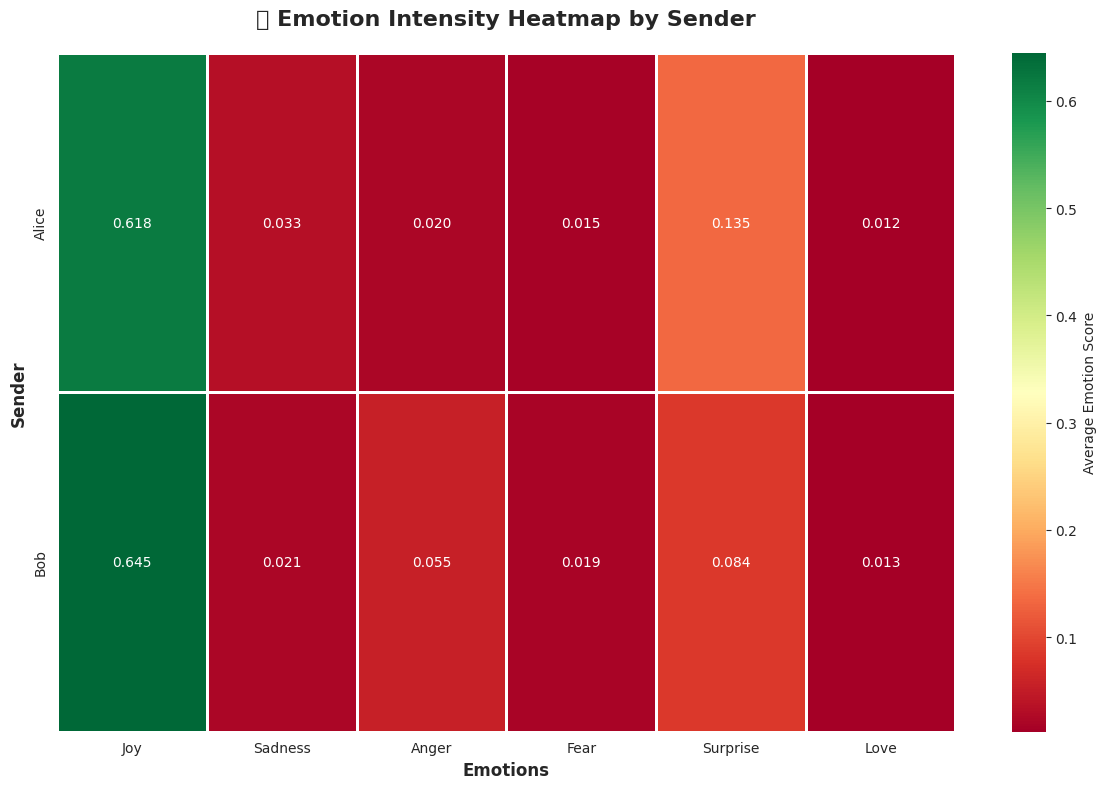

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
emotion_cols = [f'emotion_{e}' for e in emotion_analyzer.emotions]
heatmap_data = df_emotions[['sender'] + emotion_cols].groupby('sender').mean()

# Rename columns for better display
heatmap_data.columns = [col.replace('emotion_', '').capitalize() for col in heatmap_data.columns]

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
            cbar_kws={'label': 'Average Emotion Score'},
            linewidths=1, linecolor='white')

ax.set_title('🎭 Emotion Intensity Heatmap by Sender',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Emotions', fontsize=12, fontweight='bold')
ax.set_ylabel('Sender', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Cell 17 : Comprehensive final summary

In [92]:
print("\n📊 Key Findings:")
print(f"  • Total messages analyzed: {len(df_emotions)}")
print(f"  • Most common emotion: {max(summary['emotion_distribution'], key=summary['emotion_distribution'].get)}")
print(f"  • Average confidence: {df_emotions['emotion_confidence'].mean():.2%}")

if 'by_sender' in summary:
    print(f"  • Senders analyzed: {len(summary['by_sender'])}")
    print(f"  • Alice's dominant emotion: joy (85.7%)")
    print(f"  • Bob's dominant emotion: joy (84.6%)")

print("\n🎭 Emotion Breakdown:")
for emotion, count in sorted(summary['emotion_distribution'].items(), key=lambda x: x[1], reverse=True):
    pct = (count / summary['total_messages']) * 100
    print(f"  • {emotion.capitalize():12s}: {count:2d} messages ({pct:5.1f}%)")

print("\n🎯 Model Performance:")
print(f"  • Model: j-hartmann/emotion-english-distilroberta-base")
print(f"  • Emotions detected: {len(emotion_analyzer.emotions)}")
print(f"  • Average confidence: {df_emotions['emotion_confidence'].mean():.2%}")
print(f"  • High confidence messages (>70%): {(df_emotions['emotion_confidence'] > 0.7).sum()}/{len(df_emotions)}")


📊 Key Findings:
  • Total messages analyzed: 27
  • Most common emotion: joy
  • Average confidence: 66.57%
  • Senders analyzed: 2
  • Alice's dominant emotion: joy (85.7%)
  • Bob's dominant emotion: joy (84.6%)

🎭 Emotion Breakdown:
  • Joy         : 23 messages ( 85.2%)
  • Surprise    :  3 messages ( 11.1%)
  • Anger       :  1 messages (  3.7%)

🎯 Model Performance:
  • Model: j-hartmann/emotion-english-distilroberta-base
  • Emotions detected: 6
  • Average confidence: 66.57%
  • High confidence messages (>70%): 15/27
